In [1]:
from importlib import reload
import os
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

from transformers import (
    GPT2Tokenizer, AutoTokenizer
)

## dataset

In [5]:
path = '/media/data/soroosh/archived_projects/Ganjoor-crawler/data/'
poets = list(filter(lambda x: len(os.listdir(path + x)) ,os.listdir(path)))
len(poets)

76

In [6]:
df = pd.DataFrame(columns=['poet', 'poem'])
for poet in tqdm(poets):
    poems = os.listdir(path + poet)
    for poem in poems:
        poem = json.load(open(path + poet + '/' + poem))['poem']
        if len(poem):
            df = df.append({'poet': poet, 'poem' : poem}, ignore_index=True)
print(df.shape)
df.head()

  0%|          | 0/76 [00:00<?, ?it/s]

(64276, 2)


,poet,poem
0,khosro,همه شب در دلم آن کافر خون خوار می گردد\nحریر ب...
1,khosro,آن سخن گفتن تو هست هنوزم در گوش\nوان شکر خندهٔ...
2,khosro,ماهی گذشت و شب نخفت این دیده بیدار من\nیادی نک...
3,khosro,جان من از بی‌دلان آخر گهی یادی بکن\nور به انصا...
4,khosro,محمد کایت نورست رویش\nسواد روشن و اللیل، مویش\...


In [7]:
alphabet = set()
for s in tqdm(df['poem']):
    alphabet.update(list(s))
len(alphabet)

  0%|          | 0/64276 [00:00<?, ?it/s]

194

In [9]:
char2ignore = ['\t', '\r', '!', '"', '(', ')', '*', '+', ',', '-', '.', '/', '0', ':', '=', '?', '[', ']', '_', 'c', 'h', 'i', 'k', 'o', 'v', '{', '}', '\x7f', '\x9d', '\xa0', '«', '¬', '\xad', '·', '¹', '»', '÷', '،', '؛', '؟', '۰', '۱', '۲', '۳', '۴', '۵', '۶', '۷', '۸', '۹',  'ً', 'ٌ', 'ٍ', 'َ', 'ُ', 'ِ', 'ّ', 'ْ', 'ٓ', 'ٔ', 'ٖ', 'ٙ', '١', '٣', '٬','ٰ', '۔', 'ۤ', '۫', 'ﷺ', 'ﹼ', '\u2003', '\u200b', '\u200d', '\u200e', '\u200f', '–', '‘', '’', '“', '”', '…', '\u202a', '\u202b', '\u202c', '\u206e', '《', '》',]
remove_special_chars = lambda x : ''.join([c for c in x if c not in char2ignore]).replace( '\u200c', ' ')

char_group_map = {
    ''.join(['آ', 'أ', 'إ', 'ﺁ', 'ﺍ', 'ﺎ','ٱ', 'ٲ']) : 'ا',
    ''.join(['ؤ','و','ٶ','ﺆ','ﻭ', 'ﻮ']) : 'و',
    ''.join(['ئ', 'ى','ی', 'ې', 'ﯾ', 'ﯿ', 'ﻰ', 'ﻳ']) : 'ی',
    ''.join(['ب','ٻ','ﺑ']) : 'ب',
    ''.join(['ة', 'ه','ھ', 'ۀ','ﻩ', 'ﻪ', 'ە']) : 'ه',
    ''.join(['ت', 'ٹ', 'ﺕ', 'ﺖ', 'ﺗ', 'ﺘ',]) : 'ت',
    ''.join(['ج', 'ﺟ', 'ﺠ']) : 'ج',
    ''.join(['ﻣ', 'ﻤ', 'م',]) : 'م',
    ''.join(['ﻥ','ﻦ','ﻧ', 'ﻨ','ن','ں']) : 'ن',
    ''.join(['ﻟ', 'ﻠ', 'ڵ','ل',]) : 'ل',
    ''.join(['ﻑ', 'ﻓ', 'ﻔ','ف',]) : 'ف',
    ''.join(['ﻘ','ق',]) : 'ق',
    ''.join(['ﺳ','س',]) : 'س',
    ''.join(['ﮏ', 'ﮑ','ﻜ', 'ک',]) : 'ک',
    ''.join(['ﺧ', 'ﺨ','خ',]) : 'خ',
    ''.join(['ﭘ', 'پ',]) : 'پ',
    ''.join(['ﺩ', 'ﺪ', 'ڈ','د',]) : 'د',
    ''.join(['ﺭ', 'ﺮ','ر',]) : 'ر',
    ''.join(['ﺻ', 'ص',]) : 'ص',
    ''.join(['ځ','ح',]) : 'ح',
    ''.join(['ﺰ','ز',]) : 'ز',
    ''.join(['ﭼ','چ',]) : 'چ',
    ''.join(['ﮓ', 'گ']) : 'گ',
    ''.join(['ﺶ', 'ش',]) : 'ش',
    ''.join(['ﻋ']) : 'ء',
    ''.join(['ﺫ','ذ',]) : 'ذ',
}
char_map = {}
for k in char_group_map:
    for x in k:
        char_map[x] = char_group_map[k]

def replace_chars(x):
    x = x.replace('ﷲ', ''.join(['ا', 'ل' , 'ل', 'ه']))
    for c in set(list(x)):
        if c in char_map:
            x = x.replace(c, char_map[c])
    return x.strip()


df['poem_cleaned'] = df['poem'].progress_apply(lambda x: replace_chars(remove_special_chars(x)))

  0%|          | 0/64276 [00:00<?, ?it/s]

In [10]:
alphabet = set()
for s in tqdm(df['poem_cleaned']):
    alphabet.update(list(s))
len(alphabet)

  0%|          | 0/64276 [00:00<?, ?it/s]

35

In [11]:
df['n_verse'] = df['poem_cleaned'].progress_apply(lambda x: len(x.split('\n')))
df['n_word'] = df['poem_cleaned'].progress_apply(lambda x: len(x.split()))
df['length'] = df['poem_cleaned'].progress_apply(lambda x: len(x))

  0%|          | 0/64276 [00:00<?, ?it/s]

  0%|          | 0/64276 [00:00<?, ?it/s]

  0%|          | 0/64276 [00:00<?, ?it/s]

In [12]:
df.describe()

,n_verse,n_word,length
count,64276.000000,64276.000000,64276.000000
mean,23.843067,161.358314,695.051326
std,59.402120,354.287931,1574.578294
min,1.000000,0.000000,0.000000
25%,4.000000,29.000000,119.000000
50%,14.000000,103.000000,441.000000
75%,22.000000,163.000000,701.000000
max,6208.000000,34811.000000,158050.000000


In [13]:
df = df[df.n_verse > 1]
df.describe()

,n_verse,n_word,length
count,64274.000000,64274.000000,64274.000000
mean,23.843778,161.363257,695.072611
std,59.402908,354.292334,1574.598167
min,2.000000,7.000000,30.000000
25%,4.000000,29.000000,119.000000
50%,14.000000,103.000000,441.000000
75%,22.000000,163.000000,701.000000
max,6208.000000,34811.000000,158050.000000


In [15]:
poet_map = {
    'khosro': 'امیرخسرو دهلوی',
    'moulavi' : 'مولانا',
    'varavini' : 'سعدالدین وراوینی',
    'monshi' : 'نصرالله منشی',
    'farrokhi': 'فرخی سیستانی',
    'bahaee' : 'شیخ بهایی',
    'anvari' : 'انوری',
    'omman' : 'عمان سامانی',
    'masood' : 'مسعود سعد سلمان',
    'forooghi' : 'فروغی بسطامی',
    'meybodi' : 'رشیدالدین میبدی',
    'attar' : 'عطار',
    'khalili' : 'خلیل الله خلیلی',
    'bahar' : 'ملک الشعرای بهار',
    'feyz' : 'فیض کاشانی',
    'ebnehesam' : 'ابن حسام خوسفی',
    'parvin' : 'پروین اعتصامی',
    'roodaki' : 'رودکی',
    'onsori': 'عنصری',
    'ouhadi' : 'اوحدی',
    'shahnematollah' : 'شاه نعمت الله ولی',
    'babaafzal' : 'باباافضل کاشانی',
    'azraghi' : 'ازرقی هروی',
    'rahi': 'رهی معیری',
    'aref' : 'عارف قزوینی',
    'amir' : 'امیر معزی',
    'homam': 'همام تبریزی',
    'mahsati': 'مهستی گنجوی',
    'naserkhosro': 'ناصرخسرو',
    'hafez': 'حافظ',
    'orfi': 'عرفی',
    'gilani': 'عبدالقادر گیلانی',
    'obeyd': 'عبید زاکانی',
    'gar': 'رشحه',
    'mohtasham': 'محتشم کاشانی',
    'salman': 'سلمان ساوجی',
    'saeb': 'صائب تبریزی',
    'asad': 'فخرالدین اسعد گرگانی',
    'ghobar' : 'غبار همدانی',
    'jami':'جامی',
    'saadi': 'سعدی',
    'shater': 'شاطرعباس صبوحی',
    'asadi': 'اسدی توسی',
    'manoochehri': 'منوچهری',
    'shahriar': 'شهریار',
    'shabestari': 'شیخ محمود شبستری',
    'eraghi': 'عراقی',
    'kesayee':'کسایی',
    'seyf': 'سیف فرغانی',
    'hatef': 'هاتف اصفهانی',
    'sanaee': 'سنایی',
    'ferdousi' : 'فردوسی',
    'hazin' : 'حزین لاهیجی',
    'vatvat': 'رشیدالدین وطواط',
    'abusaeed': 'ابوسعید ابوالخیر',
    'khojandi': 'کمال خجندی',
    'kamal': 'کمال الدین اسماعیل',
    'vahshi': 'وحشی',
    'jabali': 'عبدالواسع جبلی',
    'zahir': 'ظهیر فاریابی',
    'fayez': 'فایز',
    'babataher': 'باباطاهر',
    'khajoo': 'خواجوی کرمانی',
    'samet': 'صامت بروجردی',
    'hojviri': 'هجویری',
    'ghodsi': 'قدسی مشهدی',
    'nezari': 'حکیم نزاری',
    'bidel': 'بیدل دهلوی',
    'helali': 'هلالی جغتایی',
    'khaghani': 'خاقانی',
    'iqbal': 'اقبال لاهوری',
    'ghaani': 'قاآنی',
    'khayyam': 'خیام',
    'razi': 'رضي الدین آرتیمانی'
}
df['poet_fa'] = df['poet'].progress_apply(lambda x: poet_map[x])

  0%|          | 0/64274 [00:00<?, ?it/s]

In [16]:
df.head()

,poet,poem,poem_cleaned,n_verse,n_word,length
0,امیرخسرو دهلوی,همه شب در دلم آن کافر خون خوار می گردد\nحریر ب...,همه شب در دلم ان کافر خون خوار می گردد\nحریر ب...,18,170,702
1,امیرخسرو دهلوی,آن سخن گفتن تو هست هنوزم در گوش\nوان شکر خندهٔ...,ان سخن گفتن تو هست هنوزم در گوش\nوان شکر خنده ...,6,50,202
2,امیرخسرو دهلوی,ماهی گذشت و شب نخفت این دیده بیدار من\nیادی نک...,ماهی گذشت و شب نخفت این دیده بیدار من\nیادی نک...,18,168,697
3,امیرخسرو دهلوی,جان من از بی‌دلان آخر گهی یادی بکن\nور به انصا...,جان من از بی دلان اخر گهی یادی بکن\nور به انصا...,6,46,205
4,امیرخسرو دهلوی,محمد کایت نورست رویش\nسواد روشن و اللیل، مویش\...,محمد کایت نورست رویش\nسواد روشن و اللیل مویش\n...,20,112,509


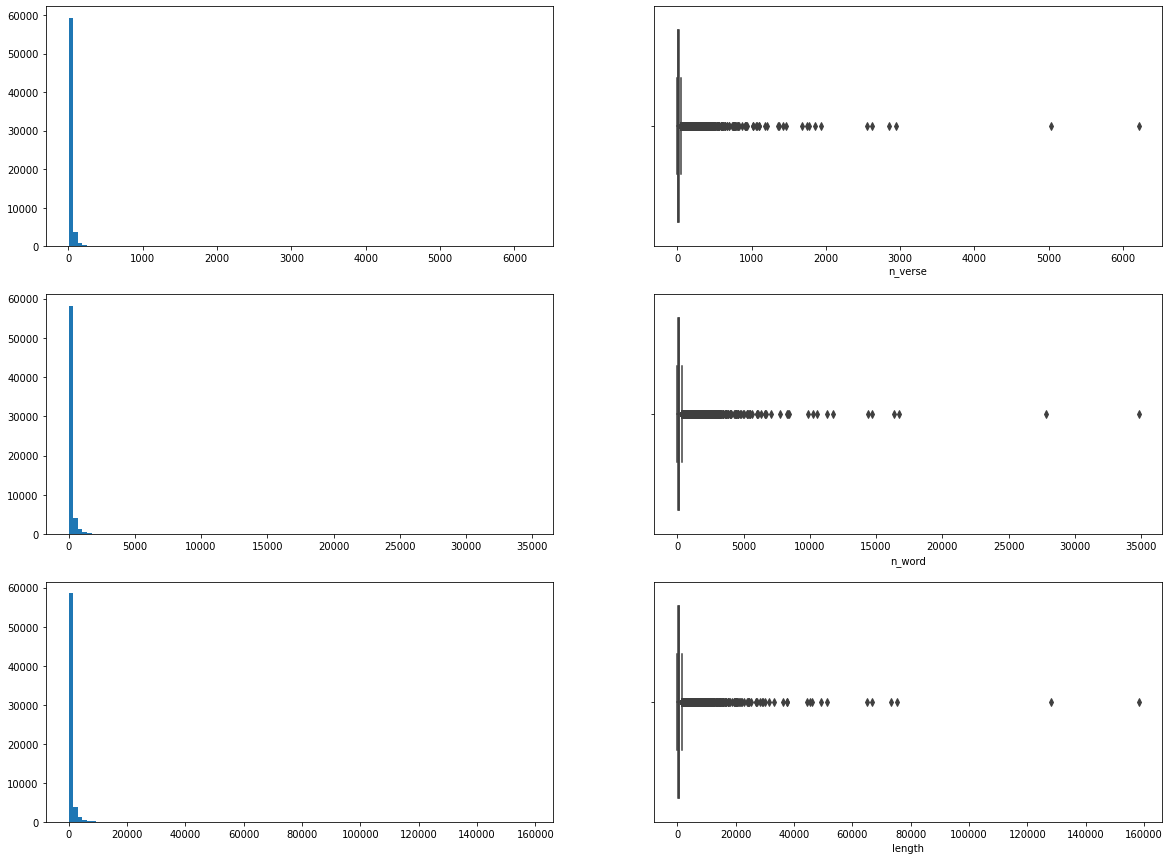

In [17]:
plt.figure(figsize=(20,15))
for i,col in enumerate(['n_verse', 'n_word', 'length']):
    plt.subplot(3,2,2*i+1)
    plt.hist(df[col], 100)
    plt.subplot(3,2,2*i+2)
    sns.boxplot(df[col])
plt.show()

In [41]:
df.to_csv('data/meta.csv', index=False)

In [40]:
df.head()

,poet,poem,poem_cleaned,n_verse,n_word,length,poet_fa
0,khosro,همه شب در دلم آن کافر خون خوار می گردد\nحریر ب...,همه شب در دلم ان کافر خون خوار می گردد\nحریر ب...,18,170,702,امیرخسرو دهلوی
1,khosro,آن سخن گفتن تو هست هنوزم در گوش\nوان شکر خندهٔ...,ان سخن گفتن تو هست هنوزم در گوش\nوان شکر خنده ...,6,50,202,امیرخسرو دهلوی
2,khosro,ماهی گذشت و شب نخفت این دیده بیدار من\nیادی نک...,ماهی گذشت و شب نخفت این دیده بیدار من\nیادی نک...,18,168,697,امیرخسرو دهلوی
3,khosro,جان من از بی‌دلان آخر گهی یادی بکن\nور به انصا...,جان من از بی دلان اخر گهی یادی بکن\nور به انصا...,6,46,205,امیرخسرو دهلوی
4,khosro,محمد کایت نورست رویش\nسواد روشن و اللیل، مویش\...,محمد کایت نورست رویش\nسواد روشن و اللیل مویش\n...,20,112,509,امیرخسرو دهلوی


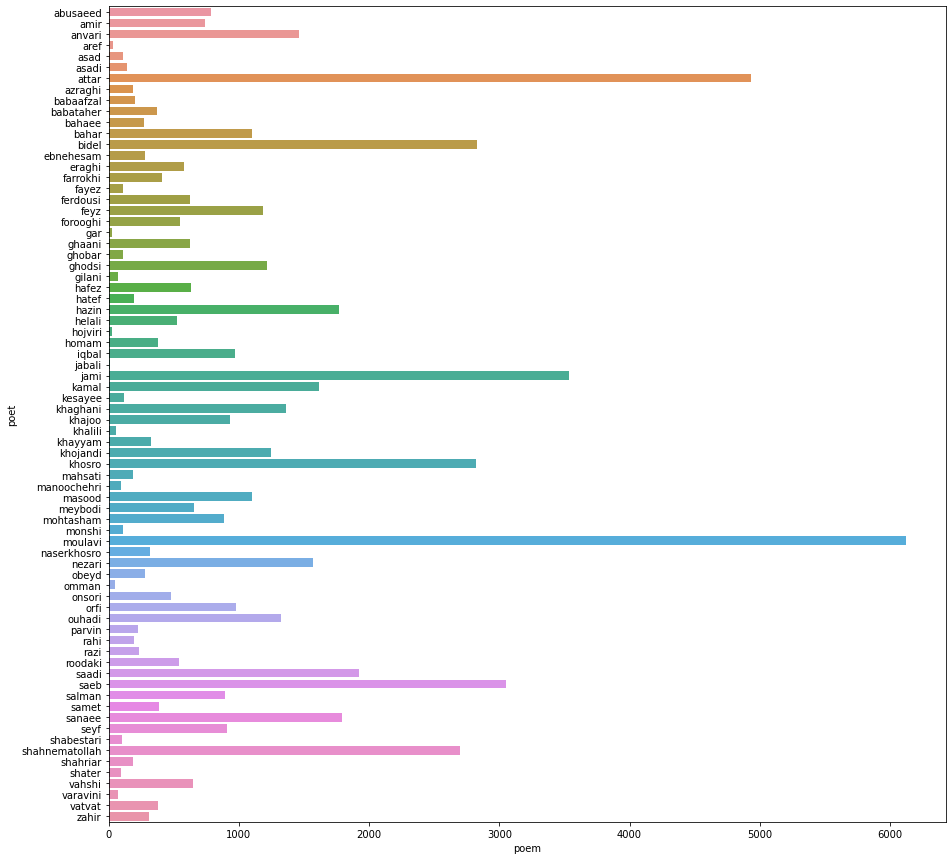

In [44]:
hist = df.groupby(['poet']).count()['poem']
plt.figure(figsize=(15,15))
sns.barplot(x=hist, y=hist.index)
plt.savefig('data/poet_hist.png')

In [278]:
df['poem_processed'] = df.progress_apply(lambda x: x['poet'] + '<|startoftext|>' + x['poem'].replace('\n', '<sep>'), axis=1)

  0%|          | 0/64251 [00:00<?, ?it/s]

In [279]:
json.dump(df['poem_processed'].tolist(), open('data/all_poems.json', 'w'))

In [2]:
df = pd.read_csv('data/meta.csv')
df.head()

,poet,poem,poem_cleaned,n_verse,n_word,length,poet_fa
0,khosro,همه شب در دلم آن کافر خون خوار می گردد\nحریر ب...,همه شب در دلم ان کافر خون خوار می گردد\nحریر ب...,18,170,702,امیرخسرو دهلوی
1,khosro,آن سخن گفتن تو هست هنوزم در گوش\nوان شکر خندهٔ...,ان سخن گفتن تو هست هنوزم در گوش\nوان شکر خنده ...,6,50,202,امیرخسرو دهلوی
2,khosro,ماهی گذشت و شب نخفت این دیده بیدار من\nیادی نک...,ماهی گذشت و شب نخفت این دیده بیدار من\nیادی نک...,18,168,697,امیرخسرو دهلوی
3,khosro,جان من از بی‌دلان آخر گهی یادی بکن\nور به انصا...,جان من از بی دلان اخر گهی یادی بکن\nور به انصا...,6,46,205,امیرخسرو دهلوی
4,khosro,محمد کایت نورست رویش\nسواد روشن و اللیل، مویش\...,محمد کایت نورست رویش\nسواد روشن و اللیل مویش\n...,20,112,509,امیرخسرو دهلوی


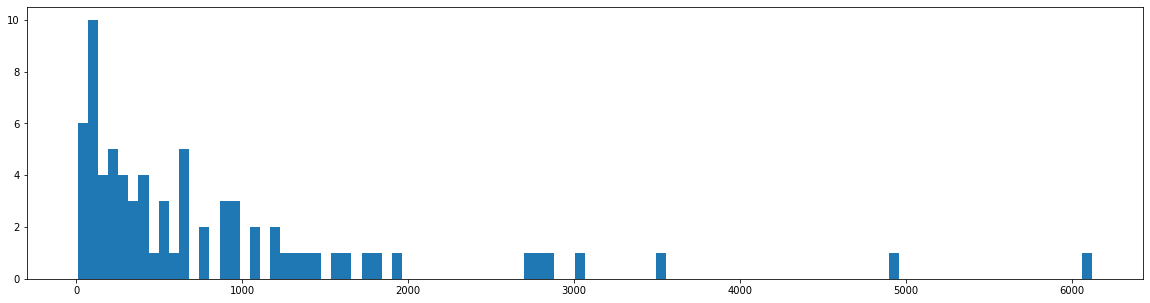

In [8]:
plt.figure(figsize=(20,5))
plt.hist(df.groupby(['poet']).count()['poem'], 100)
plt.show()

In [12]:
counts = df.groupby(['poet']).count()['poem']
filtered_counts = counts[counts > 200]
filtered_counts.sum()

61774

In [ ]:
df[pd.isin(filtered_counts)]